<a href="https://colab.research.google.com/github/ashikshezan/data-science/blob/master/ML/titanic_death_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf  # now import the tensorflow module

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [2]:
# Loading the dataset
df_train = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv") # training data
df_eval = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv") # testing data

df_train.head(3)

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y


In [3]:
# seperating the target/label from the features
y_train = df_train.pop("survived")
y_eval = df_eval.pop("survived")

### Insights of the Data

In [4]:
# some data inspection
print("Shape: ", df_train.shape)
df_train.describe()

Shape:  (627, 9)


,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


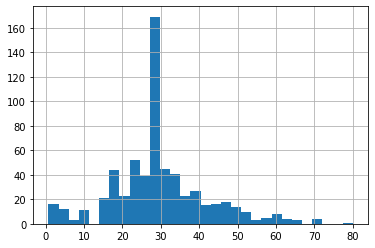

In [5]:
df_train["age"].hist(bins=30)

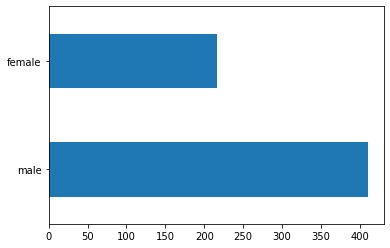

In [6]:
df_train["sex"].value_counts().plot(kind="barh") # 'barh'-> horizontal bar

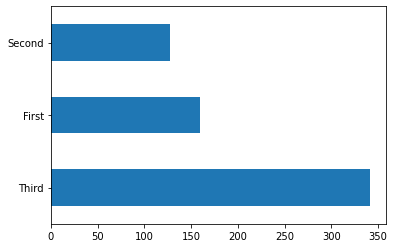

In [7]:
df_train["class"].value_counts().plot(kind="barh")

### Selecting the Feature Columns
In our dataset we have two different kinds of information: **Categorical and Numeric**

Our **categorical data** is anything that is not numeric! For example, the sex column does not use numbers, it uses the words "male" and "female".

Before we continue and create/train a model we must convet our categorical data into numeric data. We can do this by encoding each category with an integer (ex. male = 1, female = 2). 

Fortunately for us TensorFlow has some tools to help!

In [8]:
CATEGORICAL_COLUMNS = ['sex', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age','n_siblings_spouses','parch', 'fare']

feature_columns = []

for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = df_train[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

feature_columns

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='n_siblings_spouses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='parch', shape=(1,)

### The Training Process
So, we are almost done preparing our dataset and I feel as though it's a good time to explain how our model is trained. Specifically, how input data is fed to our model. 

For this specific model data is going to be streamed into it in small batches of 32. This means we will not feed the entire dataset to our model at once, but simply small batches of entries. We will feed these batches to our model multiple times according to the number of **epochs**. 

An **epoch** is simply one stream of our entire dataset. The number of epochs we define is the amount of times our model will see the entire dataset. We use multiple epochs in hope that after seeing the same data multiple times the model will better determine how to estimate it.

Ex. if we have 10 ephocs, our model will see the same dataset 10 times. 

Since we need to feed our data in batches and multiple times, we need to create something called an **input function**. The input function simply defines how our dataset will be converted into batches at each epoch.





###Input Function
The TensorFlow model we are going to use requires that the data we pass it comes in as a ```tf.data.Dataset``` object. This means we must create a *input function* that can convert our current pandas dataframe into that object. 

Below you'll see a seemingly complicated input function, this is straight from the TensorFlow documentation (https://www.tensorflow.org/tutorials/estimator/linear). I've commented as much as I can to make it understandble, but you may want to refer to the documentation for a detailed explination of each method.

In [11]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(df_train, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(df_eval, y_eval, num_epochs=1, shuffle=False)


###Creating the Model
In this tutorial we are going to use a linear estimator to utilize the linear regression algorithm. 

Creating one is pretty easy! Have a look below.



In [12]:
# We create a linear estimtor by passing the feature columns we created earlier
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpfxkr7eqy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


###Training the Model
Training the model is as easy as passing the input functions that we created earlier.

In [15]:
# training model with the traing dataset -> df_train ->  -> train_input_fn
linear_est.train(train_input_fn)

result = linear_est.evaluate(eval_input_fn)

# clears console output
clear_output()  

# the result variable is simply a dict of stats about our model
print(result['accuracy'])

0.77272725


In [22]:
# details inspection of 'results' object 

from pprint import pprint
pprint(result)

{'accuracy': 0.77272725,
 'accuracy_baseline': 0.625,
 'auc': 0.8401592,
 'auc_precision_recall': 0.79146355,
 'average_loss': 0.4746585,
 'global_step': 600,
 'label/mean': 0.375,
 'loss': 0.46138838,
 'precision': 0.7241379,
 'prediction/mean': 0.3389291,
 'recall': 0.6363636}


###Making Prediction
We can use the ```.predict()``` method to get survival probabilities from the model. This method will return a list of dicts that store a predicition for each of the entries in our testing data set. Below we've used some pandas magic to plot a nice graph of the predictions.

In [27]:
# making prediction with the testing dataset -> df_eval -> y_eval -> eval_input_fn
predictrion_results = list(linear_est.predict(eval_input_fn))

# clears console output
clear_output()

pprint(predictrion_results[0])

{'all_class_ids': array([0, 1], dtype=int32),
 'all_classes': array([b'0', b'1'], dtype=object),
 'class_ids': array([0]),
 'classes': array([b'0'], dtype=object),
 'logistic': array([0.05760369], dtype=float32),
 'logits': array([-2.7948384], dtype=float32),
 'probabilities': array([0.9423962 , 0.05760373], dtype=float32)}


In [35]:
# Checking the prediction results by mapping with every person stat
def check_prediction_result(person_index):
    print("Passanger stat: ")
    pprint(df_eval.loc[person_index])

    print(f"Actual survival result: \t{y_eval.loc[person_index]}\n")

    print("Prediction result: ")
    pprint(predictrion_results[person_index]['probabilities'])

# checking result for a given passenger index
check_prediction_result(4)

Passanger stat: 
sex                          male
age                            34
n_siblings_spouses              0
parch                           0
fare                           13
class                      Second
deck                            D
embark_town           Southampton
alone                           y
Name: 4, dtype: object
Actual survival result: 	1

Prediction result: 
array([0.8013391 , 0.19866095], dtype=float32)
